# Fan-Out Binary Tree

Experiment: `/network/tmp1/chenant/ant/sr_trace/2021-01-24/17-41-23`

Today: January 25, 2021

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import files

Read the dfs, filter out the LSF value function agent from the `1228` runs and use the new LSF value function agent from the `1230` runs (which has the elig traces) for comparison.

In [2]:
sfAg_in_path = '/Users/anthony/Playground/tensorboard_logs/sr_return/2021-01-24/17-41-23/small_progress.csv'

pd_df_sep = '\|\|'

In [3]:
# LSF value function agent
sf_ag_raw_df = pd.read_csv(sfAg_in_path, sep=pd_df_sep)

/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [13]:
"""
def script_get_data_df():
    # ==
    # Filter the elig trace dfs
    curdf = el_ag_raw_df[el_ag_raw_df['agentCls_name'] != 'SFReturnAgent']
    full_df = pd.concat([curdf, sf_ag_raw_df])
    return full_df

Data_df = script_get_data_df()
"""

withDate_Data_df = sf_ag_raw_df.copy(deep=True)
print(len(withDate_Data_df))
withDate_Data_df[0:3]

564480


,"2021-01-24 17:41:23,209",num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,lamb,eta_trace,...,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg,et_loss_avg
0,"2021-01-24 17:41:23,243",1000,PerfBinaryTreeEnv,"{'depth': 5, 'terminal_high_rew_prob': 1.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,...,5,8.0,8.115238,8.115238,0.0,0.0,12.8,NaN,NaN,None
1,"2021-01-24 17:41:23,249",1000,PerfBinaryTreeEnv,"{'depth': 5, 'terminal_high_rew_prob': 1.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,...,5,1.0,8.115234,8.115234,0.0,0.0,0.2,NaN,NaN,None
2,"2021-01-24 17:41:23,254",1000,PerfBinaryTreeEnv,"{'depth': 5, 'terminal_high_rew_prob': 1.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,...,5,10.0,8.114836,8.114836,0.0,0.0,20.0,NaN,NaN,None


#### Manually drop the date time column

In [16]:
Data_df = withDate_Data_df.copy(deep=True)
del Data_df['2021-01-24 17:41:23,209']
print(list(Data_df))
print(len(Data_df))
Data_df[0:3]

['num_episodes', 'envCls_name', 'env_kwargs', 'agentCls_name', 'seed', 'gamma', 'lr', 'lamb', 'eta_trace', 'use_true_reward_params', 'use_true_sf_params', 'episode_idx', 'total_steps', 'cumulative_reward', 'v_fn_rmse', 'sf_G_rmse', 'sf_matrix_rmse', 'reward_vec_rmse', 'value_loss_avg', 'reward_loss_avg', 'sf_loss_avg', 'et_loss_avg']
564480


,num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,lamb,eta_trace,use_true_reward_params,...,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg,et_loss_avg
0,1000,PerfBinaryTreeEnv,"{'depth': 5, 'terminal_high_rew_prob': 1.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,True,...,5,8.0,8.115238,8.115238,0.0,0.0,12.8,NaN,NaN,None
1,1000,PerfBinaryTreeEnv,"{'depth': 5, 'terminal_high_rew_prob': 1.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,True,...,5,1.0,8.115234,8.115234,0.0,0.0,0.2,NaN,NaN,None
2,1000,PerfBinaryTreeEnv,"{'depth': 5, 'terminal_high_rew_prob': 1.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,True,...,5,10.0,8.114836,8.114836,0.0,0.0,20.0,NaN,NaN,None


## Parameter study: TD(0) and KSF

### Sum across episode
#### NOTE: not totally correct AUC, since we are skipping many of the later episodes
Still gets the same rough estimate though maybe run a more rigorous test later.

In [24]:
def get_RMSE_summed_over_episodes(in_df):
    """
    Helper method, computes sum over all RMSEs (i.e. area under
    the curve) given independent columns
    """
    # 
    df = in_df.copy(deep=True)
    
    # ==
    # Filter for episodes
    df = df[df['episode_idx'] < 1000]
    
    # ==
    # Select for independent columns
    not_indep_cols = ['episode_idx', 'total_steps', 'cumulative_reward', 
                      'v_fn_rmse', 'sf_G_rmse','sf_matrix_rmse',
                      'reward_vec_rmse', 'value_loss_avg', 
                      'reward_loss_avg','sf_loss_avg', 'et_loss_avg']
    indep_cols = [c for c in list(df) if c not in not_indep_cols]
    
    # ==
    sum_df = df.groupby(indep_cols).sum().reset_index()
    
    # ==
    # Sum over selected portions of episode
    return sum_df
    
    
    
EpisSummed_df = get_RMSE_summed_over_episodes(Data_df)
print(len(EpisSummed_df))
EpisSummed_df[0:3]

9408


,num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,lamb,eta_trace,use_true_reward_params,...,episode_idx,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg
0,1000,PerfBinaryTreeEnv,"{'depth': 5, 'terminal_high_rew_prob': 1.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,False,...,6715,300,448.0,484.833753,484.833753,0.0,376.805092,947.737991,30.56762,0.0
1,1000,PerfBinaryTreeEnv,"{'depth': 5, 'terminal_high_rew_prob': 1.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,False,...,6715,300,448.0,484.833753,484.833753,0.0,376.805092,947.737991,30.56762,0.0
2,1000,PerfBinaryTreeEnv,"{'depth': 5, 'terminal_high_rew_prob': 1.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,True,...,6715,300,448.0,484.833753,484.833753,0.0,0.000000,947.737991,0.00000,0.0


### Plot parameter study

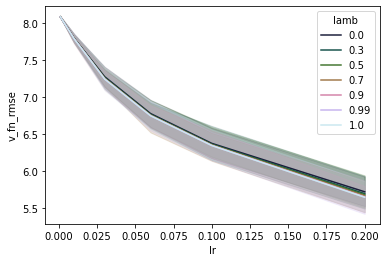

In [39]:
def lr_rmse_lineplot(data, y='v_fn_rmse', filters=None):
    # ==
    plt_x = 'lr'
    plt_hue = 'lamb'
    plt_ci = 95
    plt_n_boot = 100
    
    # ==
    # Filters
    if filters is None:
        filters = {
            'agentCls_name': 'SFReturnAgent',
            'eta_trace': 0.0,
            'env_kwargs': "{'depth': 5, 'terminal_high_rew_prob': 1.0}",
            'use_true_sf_params': False,
            'use_true_reward_params': False,
        }
    
    df = data.copy(deep=True)
    for k in filters:
        df = df[df[k] == filters[k]]
    
    # round
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    # hues
    n_hues = len(set(df[plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    
    
    sns.lineplot(x=plt_x, y=y, hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette, 
                 data=df)
    
lr_rmse_lineplot(Data_df)
#plt.yscale('log')
#plt.xscale('log')

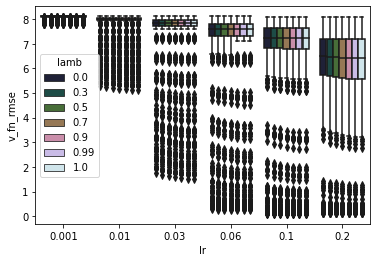

In [40]:
def lr_rmse_boxplot(data, y='v_fn_rmse', filters=None):
    # ==
    plt_x = 'lr'
    plt_hue = 'lamb'
    
    # ==
    # Filters
    if filters is None:
        filters = {
            'agentCls_name': 'SFReturnAgent',
            'eta_trace': 0.0,
            'env_kwargs': "{'depth': 5, 'terminal_high_rew_prob': 1.0}",
            'use_true_sf_params': False,
            'use_true_reward_params': False,
        }
    
    df = data.copy(deep=True)
    for k in filters:
        df = df[df[k] == filters[k]]
    
    # round
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    # hues
    n_hues = len(set(df[plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    
    
    sns.boxplot(x=plt_x, y=y, hue=plt_hue,
                 palette=c_palette, 
                 data=df)
    
lr_rmse_boxplot(Data_df)

Pausing, not sure if this is demonstrating a enviornment where the KSF is working better

# NOTE: below deprecated. Reference only.

## Compare: TD(0) with LSF
### Parameter study

In [58]:
def script_helper_true_param_filter(in_df, filters):
    """Helper for filtering the different true param settings"""
    df = in_df.copy(deep=True)
    df = df[df['use_true_sf_params'] == filters[0]]
    df = df[df['use_true_reward_params'] == filters[1]]
    return df

def script_plot_v_fn_rmse_td0_epis(df, n_episode_idx=9,
                                   xscale='linear', yscale='linear'):
    plt_x = 'lr'
    plt_y = 'v_fn_rmse'
    plt_hue = 'lamb'
    plt_ci = None
    plt_n_boot = 100
    
    # Filter
    df = script_helper_true_param_filter(df, [False, False])
    df = df[df['agentCls_name'] == 'SFReturnAgent']
    df = df[df['eta_trace'] == 0.0]  # no elig trace
    df = df[df['env_kwargs'] == "{'depth': 7}"]
    
    
    # round
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    
    df = df[df['episode_idx']==n_episode_idx]
    n_hues = len(set(df[plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    
    
    sns.lineplot(x=plt_x, y=plt_y, hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette, 
                 data=df)
    
    #plt.yscale([])
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')

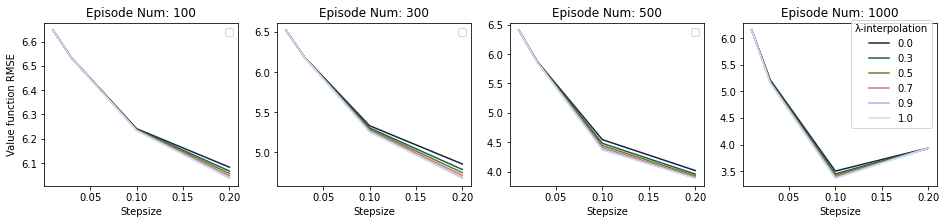

In [59]:
def script_plot_multi_v_fn_rmse_td0_epis(df, episode_idx_list):
    
    for i, epis_idx in enumerate(episode_idx_list):
        plt.subplot(1, len(episode_idx_list), (i+1))
        script_plot_v_fn_rmse_td0_epis(df, epis_idx)
        
        plt.title(f'Episode Num: {epis_idx+1}')
        plt.xlabel('Stepsize')
        # Y axis
        if i == 0:
            plt.ylabel('Value function RMSE')
        else:
            plt.ylabel('')
        
        # Legend
        if i < (len(episode_idx_list)-1):
            plt.legend([])  # assume same hues for legends
        else:
            plt.legend(title='λ-interpolation', bbox_to_anchor=(1, 1.05), )
    
    pass

plt.figure(figsize=(16,3))
script_plot_multi_v_fn_rmse_td0_epis(Data_df, 
                                     episode_idx_list=[99, 299, 499, 999])

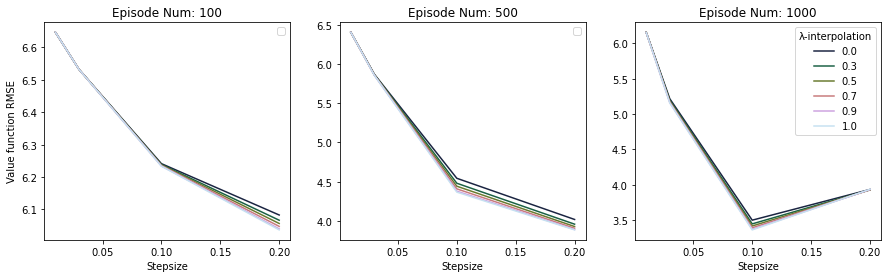

In [64]:
# Better plot
plt.figure(figsize=(15,4))
script_plot_multi_v_fn_rmse_td0_epis(Data_df, 
                                     episode_idx_list=[99, 499, 999])
plt.legend(loc='upper right', title='λ-interpolation')

### Convergence over episodes

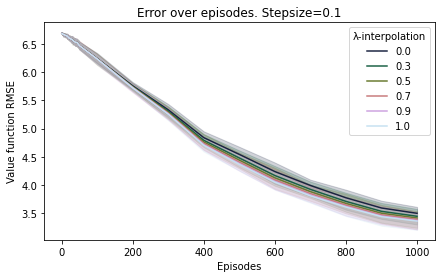

In [21]:
def script_plot_rmse_over_episodes(df, y='v_fn_rmse', hue='lamb'):
    plt_x = 'episode_idx'
    plt_y = y
    plt_hue = hue
    cur_lr = 0.1
    plt_ci = 95
    plt_n_boot = 200
    
    # Filter
    df = script_helper_true_param_filter(df, [False, False])
    df = df[df['agentCls_name'] == 'SFReturnAgent']
    df = df[df['eta_trace'] == 0.0]  # no elig trace
    df = df[df['lr'] == cur_lr]  # no elig trace
    df = df[df['env_kwargs'] == "{'depth': 7}"]
    
    
    # round
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    
    n_hues = len(set(df[plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    
    
    sns.lineplot(x=plt_x, y=plt_y, hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette, 
                 data=df)
    
    plt.title(f'Error over episodes. Stepsize={cur_lr}')
    plt.ylabel('Value function RMSE')
    plt.xlabel('Episodes')
    plt.legend(title='λ-interpolation')

plt.figure(figsize=(7,4))
script_plot_rmse_over_episodes(Data_df, y='v_fn_rmse', hue='lamb')

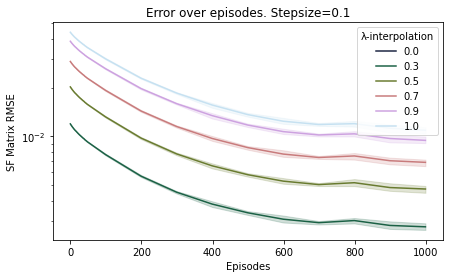

In [22]:
plt.figure(figsize=(7,4))
script_plot_rmse_over_episodes(Data_df, y='sf_matrix_rmse', hue='lamb')
plt.ylabel('SF Matrix RMSE')
plt.yscale('log')

## Comparison: LSF with TD(lambda)

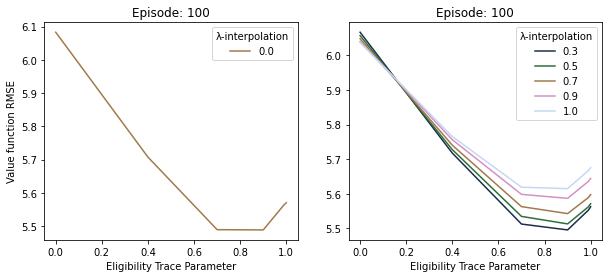

In [77]:
def script_plot_trace_best_stepsize(df, episode_idx=9, true_param_filter=[False,False], ylim=None):
    plt_x = 'eta_trace'
    plt_y = 'v_fn_rmse'
    plt_hue = 'lamb'
    plt_ci = None
    plt_n_boot = 200
    
    # ==
    # Filter
    df = script_helper_true_param_filter(df, true_param_filter)
    df = df[df['agentCls_name'] == 'SFReturnAgent']
    df = df[df['episode_idx'] == episode_idx]
    df = df[df['env_kwargs'] == "{'depth': 7}"]
    
    # Filter for TD(lambda)
    tdlamb_df = df[df['lamb'] == 0.0] 
    # Filter for LSF
    lsf_df = df[df['lamb'] > 0.0]
    
    # ==
    # Find best lr parameters
    def best_lr_df(cur_df):
        cur_df = cur_df.groupby(['lamb', 'eta_trace', 'lr']).mean()
        cur_df_mask = cur_df.groupby(['lamb','eta_trace'])['v_fn_rmse'].transform(min) == cur_df['v_fn_rmse']
        cur_df = cur_df[cur_df_mask]
        return cur_df.reset_index()
    
    best_lr_df_dict = {}
    best_lr_df_dict['td_lambda'] = best_lr_df(tdlamb_df)
    best_lr_df_dict['lsf'] = best_lr_df(lsf_df)
    
    # ==
    # Plot
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    n_hues = len(set(best_lr_df_dict['td_lambda'][plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    sns.lineplot(x=plt_x, y=plt_y, hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette, 
                 data=best_lr_df_dict['td_lambda'])
    plt.ylim(ylim)
    plt.title(f'Episode: {episode_idx+1}')
    plt.ylabel('Value function RMSE')
    plt.xlabel('Eligibility Trace Parameter')
    plt.legend(title='λ-interpolation')
    
    
    plt.subplot(1,2,2)
    n_hues = len(set(best_lr_df_dict['lsf'][plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    sns.lineplot(x=plt_x, y=plt_y, hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette, 
                 data=best_lr_df_dict['lsf'])
    plt.ylim(ylim)
    plt.title(f'Episode: {episode_idx+1}')
    plt.ylabel('')
    plt.xlabel('Eligibility Trace Parameter')
    plt.legend(title='λ-interpolation')
    
    
    return best_lr_df_dict
    

cur_out_dict = script_plot_trace_best_stepsize(Data_df, episode_idx=99, 
                                               true_param_filter=[False,False], 
                                               ylim=None)

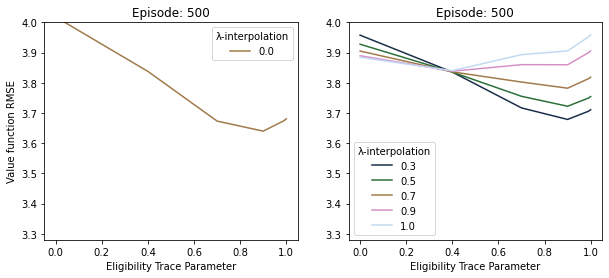

In [78]:
cur_out_dict = script_plot_trace_best_stepsize(Data_df, episode_idx=499, 
                                               true_param_filter=[False,False], 
                                               ylim=[3.28, 4.0])

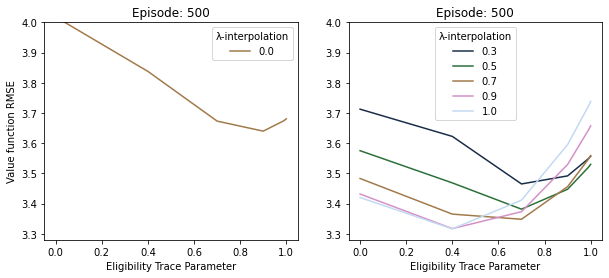

In [79]:
cur_out_dict = script_plot_trace_best_stepsize(Data_df, episode_idx=499, 
                                               true_param_filter=[False,True], 
                                               ylim=[3.28, 4.0])

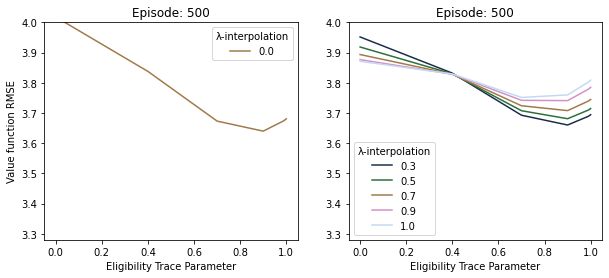

In [80]:
cur_out_dict = script_plot_trace_best_stepsize(Data_df, episode_idx=499, 
                                               true_param_filter=[True,False], 
                                               ylim=[3.28, 4.0])

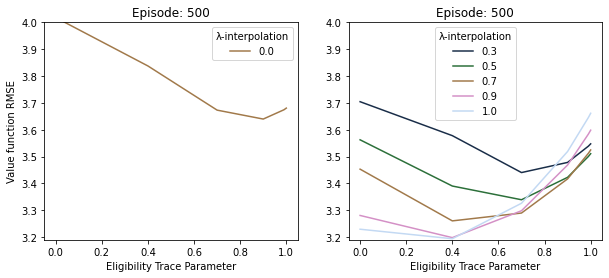

In [81]:
cur_out_dict = script_plot_trace_best_stepsize(Data_df, episode_idx=499, 
                                               true_param_filter=[True,True], 
                                               ylim=[3.19, 4.0])

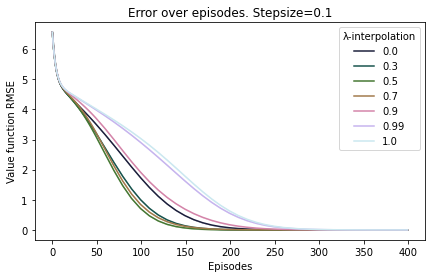

In [18]:
def script_plot_rmse_fixed_lr_trace_over_episodes(df, y='v_fn_rmse', hue='lamb'):
    plt_x = 'episode_idx'
    plt_y = y
    plt_hue = hue
    cur_lr = 0.1
    plt_ci = 95
    plt_n_boot = 200
    
    # Filter
    df = script_helper_true_param_filter(df, [False, False])
    df = df[df['agentCls_name'] == 'SFReturnAgent']
    df = df[df['eta_trace'] == 0.4]  # no elig trace
    df = df[df['lr'] == cur_lr]  # no elig trace
    
    
    # round
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    
    n_hues = len(set(df[plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    
    
    sns.lineplot(x=plt_x, y=plt_y, hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette, 
                 data=df)
    
    plt.title(f'Error over episodes. Stepsize={cur_lr}')
    plt.ylabel('Value function RMSE')
    plt.xlabel('Episodes')
    plt.legend(title='λ-interpolation')

plt.figure(figsize=(7,4))
script_plot_rmse_fixed_lr_trace_over_episodes(Data_df, y='v_fn_rmse', hue='lamb')